In [5]:
#(1) SetUp Environment

In [517]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

In [519]:
#limit our memory growth(only allocates required memory when running)
gpus = tf.config.experimental.list_physical_devices("GPU")
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu,"True")

In [522]:
#(2) Data Load

In [916]:
data_dir = "/Users/norbujamling/Desktop/mydatanew/smalltrain"
image_size = (60,1400)

In [954]:
# List all image files in the directory
file_paths = tf.data.Dataset.list_files(data_dir + '/*.jpg')

# Read and decode images from file paths
def parse_image(filename):
    image = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image, channels=1)  # 1 channel for black and white images
    image = tf.image.resize(image, image_size)
    image = image / 255.0
    return image

# Parse images and create dataset
dataset = file_paths.map(parse_image)

dataset = np.array(list(dataset.as_numpy_iterator()))
# Take only the left half of each image
dataset = dataset[:, :, 670:730]
dataset.shape
dataset = tf.data.Dataset.from_tensor_slices(dataset)

# Iterate over the dataset and print the shape of each image
#for i, image in enumerate(dataset):
#    print(f"Image {i + 1} Shape:", image.shape)

2024-06-05 16:54:28.036838: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


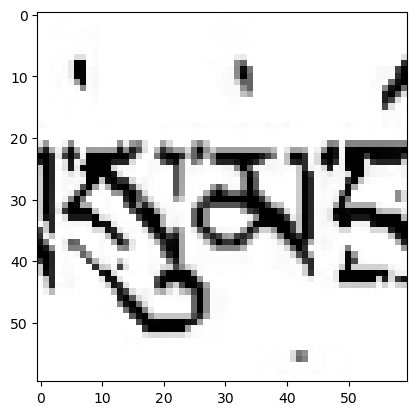

In [958]:
# Visualize the first image in the dataset
sample_image = next(iter(dataset))
plt.imshow(sample_image[:, :, 0], cmap='gray') 
plt.show()

In [960]:
# Convert each image to a 1D array
def flatten_image(image):
    return tf.reshape(image, (-1,))

dataset = dataset.map(flatten_image)

# Iterate over the dataset and print the shape of each image
#for i, image in enumerate(dataset):
#    print(f"Image {i + 1} Shape:", image.shape)

In [962]:
# Reshape each flattened image back to 2D
#def reshape_image(image):
#    return tf.reshape(image, image_size)

#dataset_reshaped = dataset.map(reshape_image)

# Iterate over the dataset and print the shape of each image
#for i, image in enumerate(dataset_reshaped):
#    print(f"Image {i + 1} Shape:", image.shape)

In [964]:
# Visualize the first image in the reshaped dataset
#sample_image = next(iter(dataset_reshaped))
#plt.imshow(sample_image, cmap='gray') 
#plt.title("Sample Image")
#plt.axis("off")
#plt.show()

In [966]:
#(3) Build Generator and Discriminator

In [968]:
latent_dim = 100
input_shape = (60*60,)  # Flattened shape

In [970]:
def build_generator(latent_dim):
    model = models.Sequential()
    model.add(layers.Dense(16, input_dim=latent_dim))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dense(60*60, activation='sigmoid'))
    return model

In [972]:
# Build the generator
generator = build_generator(latent_dim)
generator.summary()

Model: "sequential_28"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_56 (Dense)                │ (None, 16)             │         1,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_29 (LeakyReLU)      │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_57 (Dense)                │ (None, 3600)           │        61,200 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 62,816 (245.38 KB)

 Trainable params: 62,816 (245.38 KB)

 Non-trainable params: 0 (0.00 B)

In [974]:
def build_discriminator(input_shape):
    model = models.Sequential()
    model.add(layers.Dense(8, input_shape=input_shape))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dense(1, activation='sigmoid'))
    return model

In [976]:
# Build the discriminator
discriminator = build_discriminator(input_shape)
discriminator.summary()

Model: "sequential_29"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_58 (Dense)                │ (None, 8)              │        28,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_30 (LeakyReLU)      │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_59 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,817 (112.57 KB)

 Trainable params: 28,817 (112.57 KB)

 Non-trainable params: 0 (0.00 B)

In [978]:
#(4) Backpropagation

In [1010]:
# Define loss functions
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# Discriminator loss function
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

# Generator loss function
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

# Define optimizers
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-5)


In [1012]:
# Training loop
def train_step(images):
    noise = tf.random.normal([32, 100])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [1016]:
dataset_array = np.array(list(dataset.as_numpy_iterator()))

# Set batch size
BATCH_SIZE = 32

# Split the dataset into batches
num_batches = len(dataset_array) // BATCH_SIZE

# Training loop
epochs = 100
for epoch in range(epochs):
    np.random.shuffle(dataset_array)  # Shuffle the dataset at the beginning of each epoch
    for i in range(num_batches):
        batch_images = dataset_array[i*BATCH_SIZE:(i+1)*BATCH_SIZE]
        train_step(batch_images)
    print(f'Epoch {epoch+1}/{epochs}')

2024-06-05 16:56:48.018436: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 1/100
Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100
Epoch 23/100
Epoch 24/100
Epoch 25/100
Epoch 26/100
Epoch 27/100
Epoch 28/100
Epoch 29/100
Epoch 30/100
Epoch 31/100
Epoch 32/100
Epoch 33/100
Epoch 34/100
Epoch 35/100
Epoch 36/100
Epoch 37/100
Epoch 38/100
Epoch 39/100
Epoch 40/100
Epoch 41/100
Epoch 42/100
Epoch 43/100
Epoch 44/100
Epoch 45/100
Epoch 46/100
Epoch 47/100
Epoch 48/100
Epoch 49/100
Epoch 50/100
Epoch 51/100
Epoch 52/100
Epoch 53/100
Epoch 54/100
Epoch 55/100
Epoch 56/100
Epoch 57/100
Epoch 58/100
Epoch 59/100
Epoch 60/100
Epoch 61/100
Epoch 62/100
Epoch 63/100
Epoch 64/100
Epoch 65/100
Epoch 66/100
Epoch 67/100
Epoch 68/100
Epoch 69/100
Epoch 70/100
Epoch 71/100
Epoch 72/100
Epoch 73/100
Epoch 74/100
Epoch 75/100
Epoch 76/100
Epoch 77/100
Epoch 78

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


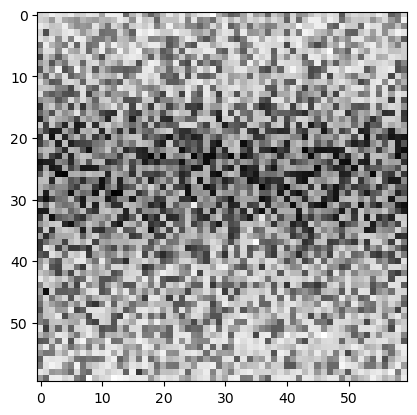

In [1044]:
image_size = (60,60)
imgs = generator.predict(tf.random.normal([32, 100]))[0]
plt.imshow(tf.reshape(imgs, image_size), cmap='gray') 
plt.show()